In [56]:
import numpy as np 
import pandas as pd
import pickle, glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime, timedelta
from collections import defaultdict
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates
import warnings

warnings.filterwarnings("ignore")

In [57]:
place = 'Keelung'

file = glob.glob(f'../Results/soundsepration/{place}_*_cluster.csv')[0]
df = pd.read_csv(file)

df_datetime = pd.DataFrame({'Datetime': [datetime.fromtimestamp(t) for t in df['Time'] ]} )
df = pd.concat([df,df_datetime], axis=1)
# df = df[~df['S1_Cluster'].isna()]

In [60]:
df_ = df.filter(regex='Cluster')
# S1_total, S3_total = [np.max(df_[key]) for key in df_.keys() ]
S1_total = [np.max(df_[key]) for key in df_.keys() ][0]
total_cluster = int(sum([ np.max(df_[key]) for key in df_.keys() ]))
# print(S1_total, S3_total)
print(total_cluster)

13


In [62]:
datelist = []

spec = defaultdict(list)
# spec = {'S1_1':[],
#        'S1_2': [],
#        'S1_3': [],
#        'S1_4': [],
#        'S3_1': [],
#        'S3_2': [],
#        'S3_3': []}

month = df['Datetime'][0].month
day = df['Datetime'][0].day
datezero = datetime(2023, month, day, 0, 0, 0)
date = datetime(2023, month, day, 23, 59, 0)

for dd in range(150):
    for hh in [23]:
        df_temp = df[df['Datetime'] < datetime(2023, date.month, date.day, hh, 59, 0)][df['Datetime'] >= datetime(2023, date.month, date.day, 0, 0, 0)]

        if len(df_temp[~df_temp['S1_Cluster'].isna()]) != 0: 

            df_temp_s1 = df_temp['S1_Cluster']
            # df_temp_s3 = df_temp['S3_Cluster']

            df_temp_c1 = set(df_temp_s1)
            # df_temp_c3 = set(df_temp_s3)

            for cc in range(1, int(S1_total)+1):
                spec[f'S1_{cc}'].append(df_temp_s1.to_list().count(cc)) 
            # for cc in range(1, int(S3_total)+1):
                # spec[f'S3_{cc}'].append(df_temp_s3.to_list().count(cc))     
        else:
            for cc in range(1, int(S1_total)+1):
                spec[f'S1_{cc}'].append(np.nan)
            # for cc in range(1, int(S3_total)+1):
                # spec[f'S3_{cc}'].append(np.nan)
        datelist.append(datetime(2023, date.month, date.day, hh))
    date = date + timedelta(days = 1) 
    
df_spec = pd.DataFrame(spec)

In [63]:
sumlist = df_spec.sum(min_count=1, axis=1)
dp = pd.DataFrame(np.array([((df_spec.values[i:i+1]).tolist()[0]/ sumlist.values[i]).tolist()  for i in range(len(df_spec))] ))
p_log = dp*np.log10(dp)
H = -1*np.sum(p_log, axis=1)
H = [h  if h != -0.000000 else np.nan for h in H ]
df_H = pd.concat([pd.DataFrame({'Time':datelist, 'H': H}) ])

In [64]:
df_spec

,S1_1,S1_2,S1_3,S1_4,S1_5,S1_6,S1_7,S1_8,S1_9,S1_10,S1_11,S1_12,S1_13
0,4.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0
1,1.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0
2,13.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0
3,7.0,0.0,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,1.0
4,13.0,0.0,0.0,22.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.0,13.0,2.0,0.0,0.0,3.0,14.0,9.0,0.0,7.0,0.0,0.0,0.0
146,0.0,10.0,5.0,0.0,2.0,3.0,8.0,10.0,0.0,10.0,0.0,0.0,0.0
147,0.0,11.0,1.0,0.0,0.0,3.0,4.0,10.0,0.0,19.0,0.0,0.0,0.0
148,0.0,15.0,1.0,0.0,0.0,3.0,8.0,5.0,0.0,16.0,0.0,0.0,0.0


In [65]:
df_H['Time'][0]

Timestamp('2023-04-17 23:00:00')

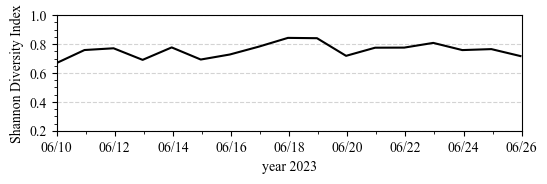

In [84]:
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 1.5))

plt.grid(axis='y', ls='--', color='lightgrey')

plt.plot(df_H['Time'], df_H['H'], 'k' )
last_index = df_H['H'][df_H['H'].isna() == False].index[-1]
# plt.xlim(df_H['Time'][0], df_H['Time'][last_index])
plt.xlim(datetime(2023,6,10), datetime(2023,6,26))
plt.ylabel('Shannon Diversity Index')
plt.ylim(0.2, 1)

plt.xlabel('year 2023')
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))

plt.savefig('qqq.png', dpi=150)
# plt.savefig(f'../Results/soundsepration/{place}_2023_index_variations.png', dpi=150 )
# plt.savefig(f'../Results/soundsepration/{place}_2023_index_variations.pdf', dpi=150 )

In [67]:
def stats_plot(data, index, ax):
    Q1 = round(np.nanpercentile(data, 25, interpolation = 'midpoint'), 3)
    Q2 = round(np.nanmedian(data),3)
    Q3 = round(np.nanpercentile(data, 75, interpolation = 'midpoint'), 3)
    IQR = Q3 - Q1
    
    upper_bound = Q3 + 1.5*IQR
    lower_bound = Q1 - 1.5*IQR
    
    upper_idx = data>=upper_bound
    lower_idx = data<=lower_bound

    if len(np.where(lower_idx)[0]) == 0 and len(np.where(upper_idx)[0]) == 0:
        drop_num = [np.nan]
    else:
        # print(f'origin Q: {Q1}, {Q2}, {Q3}')
        print('dropping ....')

        drop_num = [data.loc[i] for i in np.where(lower_idx)[0]] 
        for j in [data.loc[i] for i in np.where(upper_idx)[0]]:
            drop_num.append(j)
        
        data = data.drop(np.where(lower_idx)[0])
        data = data.drop(np.where(upper_idx)[0])

        
        Q1 = round(np.nanpercentile(data, 25, interpolation = 'midpoint'),3)
        Q2 = round(np.nanmedian(data),3)
        Q3 = round(np.nanpercentile(data, 75, interpolation = 'midpoint'),3)
    
    
    ax.plot([index, index], [np.nanmin(data), np.nanmax(data)], lw=2, color='r')
    ax.plot([index, index], [Q1, Q3], lw=7, color='r')
    ax.plot([index], [Q2], marker='o', markersize = 7, color='white', mec='k', mew=1.5)# ,edgecolors='k', lw=2
    ax.text(index+0.05, Q2, float("{:.2f}".format(Q2,2)), ha='left', va ='top', fontsize=8)
    
    if not drop_num[0] is np.nan:
        ax.scatter([index]*len(drop_num), drop_num,  marker='o', s=5, color='white', edgecolors='r', lw=2, alpha=0.2)
    
    print(index, Q1, Q2, Q3, drop_num)
    print()
    return Q1, Q2, Q3, drop_num, ax

dropping ....
1 0.489 0.536 0.572 [0.2185351133714462]

2 0.719 0.765 0.777 [nan]

dropping ....
3 0.645 0.665 0.717 [0.4611537613754211, 0.9414898314090916]



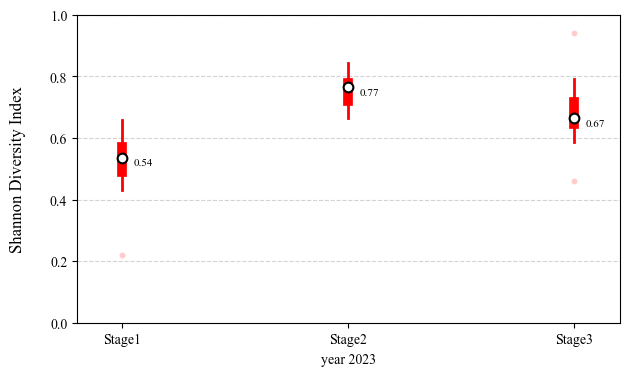

In [68]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 4))
stage1 = df_H[df_H['Time']<datetime(2023,5,15)]
Q1, Q2, Q3, drop_num, ax = stats_plot(stage1['H'], 1, ax)

stage2 = df_H[df_H['Time']<datetime(2023,7,1)][df_H['Time']>datetime(2023,6,1)]
stage2 = stage2.reset_index()
Q1, Q2, Q3, drop_num, ax = stats_plot(stage2['H'], 2, ax)

stage3 = df_H[df_H['Time']>datetime(2023,8,15)]
stage3 = stage3.reset_index()
Q1, Q2, Q3, drop_num, ax = stats_plot(stage3['H'], 3, ax)

plt.ylim(0, 1)
plt.xlim(0.8, 3.2)
plt.xlabel('year 2023')
plt.xticks(range(1, 4), ['Stage1', 'Stage2', 'Stage3'])
plt.grid(axis='y', ls='--', color='lightgrey')
plt.ylabel('Shannon Diversity Index\n', fontsize=12)

plt.savefig(f'../Results/soundsepration/{place}_2023_index_stats.png', dpi=150 )
plt.savefig(f'../Results/soundsepration/{place}_2023_index_stats.pdf', dpi=150 )